In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
#from sklearn.base import BaseEstimator, TransformerMixin
#from scipy.cluster.hierarchy import linkage, fcluster
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
## load data, pass NA value labeling (nd)

df = pd.read_csv(
    "/home/nico_kas/code/Lucia-Cordero/ReefSight-Project/raw_data/global_bleaching_environmental.csv",
    low_memory=False,
    na_values=["nd", "ND", "Nd", "nD"]
)

In [4]:
df.shape

(41361, 62)

In [5]:
df.columns

Index(['Site_ID', 'Sample_ID', 'Data_Source', 'Latitude_Degrees',
       'Longitude_Degrees', 'Ocean_Name', 'Reef_ID', 'Realm_Name',
       'Ecoregion_Name', 'Country_Name', 'State_Island_Province_Name',
       'City_Town_Name', 'Site_Name', 'Distance_to_Shore', 'Exposure',
       'Turbidity', 'Cyclone_Frequency', 'Date_Day', 'Date_Month', 'Date_Year',
       'Depth_m', 'Substrate_Name', 'Percent_Cover', 'Bleaching_Level',
       'Percent_Bleaching', 'ClimSST', 'Temperature_Kelvin',
       'Temperature_Mean', 'Temperature_Minimum', 'Temperature_Maximum',
       'Temperature_Kelvin_Standard_Deviation', 'Windspeed', 'SSTA',
       'SSTA_Standard_Deviation', 'SSTA_Mean', 'SSTA_Minimum', 'SSTA_Maximum',
       'SSTA_Frequency', 'SSTA_Frequency_Standard_Deviation',
       'SSTA_FrequencyMax', 'SSTA_FrequencyMean', 'SSTA_DHW',
       'SSTA_DHW_Standard_Deviation', 'SSTA_DHWMax', 'SSTA_DHWMean', 'TSA',
       'TSA_Standard_Deviation', 'TSA_Minimum', 'TSA_Maximum', 'TSA_Mean',
       'TSA_Freq

## DROPPING ENTRIES WITH MISSING VALUES FOR TARGET

In [6]:
## our target is 'Percent_Bleaching', drop nds

target_col = "Percent_Bleaching"
df = df.dropna(subset=[target_col])

## already define model target y here

y = df[target_col]

In [7]:
len(df)

34515

In [8]:
## drop duplicate rows

df = df.drop_duplicates()

In [9]:
len(df)

34515

In [10]:
## divide into numerical/categoricalfeatures
## after reading .csv, almost everything will be object → convert where possible

df = df.apply(pd.to_numeric, errors="ignore")

num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()

print("Numeric:", len(num_cols))
print("Categorical:", len(cat_cols))

/tmp/ipykernel_131977/1251170709.py:4: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors="ignore")


Numeric: 46
Categorical: 16


## UNDERSTANDING MISSING VALUES OF FEATURES

In [11]:
## computing missingness to explore if feature columns need to be dropped/imputed/..

missing_frac = df.isna().mean().sort_values(ascending=False)
missing_frac[missing_frac > 0.3]

## everything with missingness > 30% (drop) is meta data -> no effect
## not needed for model -> drop

Site_Comments         0.940026
Bleaching_Comments    0.922671
Sample_Comments       0.919948
Site_Name             0.800927
Substrate_Name        0.349037
Bleaching_Level       0.347211
Reef_ID               0.347211
Percent_Cover         0.343097
dtype: float64

In [12]:
cols_missing_high_to_drop = missing_frac[missing_frac > 0.30].index.tolist()
df = df.drop(columns=cols_missing_high_to_drop)

In [13]:
## recalculating missing_frac to look at features meant for imputaion
missing_frac = df.isna().mean().sort_values(ascending=False)
missing_frac[missing_frac > 0]


## mostly numerical data, but beware of categorical data (e.g. City_Town_Name - yes this particular one will be dropped eventually - just for awareness)

Depth_m                                  0.048703
City_Town_Name                           0.028162
SSTA_Minimum                             0.004114
Temperature_Kelvin                       0.003535
SSTA                                     0.003535
SSTA_Frequency                           0.003535
SSTA_DHW                                 0.003535
TSA                                      0.003535
TSA_DHW                                  0.003535
TSA_Frequency                            0.003535
Windspeed                                0.003216
Temperature_Maximum                      0.003071
SSTA_Standard_Deviation                  0.003071
SSTA_Mean                                0.003071
Temperature_Minimum                      0.003071
Temperature_Mean                         0.003071
Temperature_Kelvin_Standard_Deviation    0.003071
SSTA_Frequency_Standard_Deviation        0.003071
SSTA_Maximum                             0.003071
SSTA_FrequencyMax                        0.003071


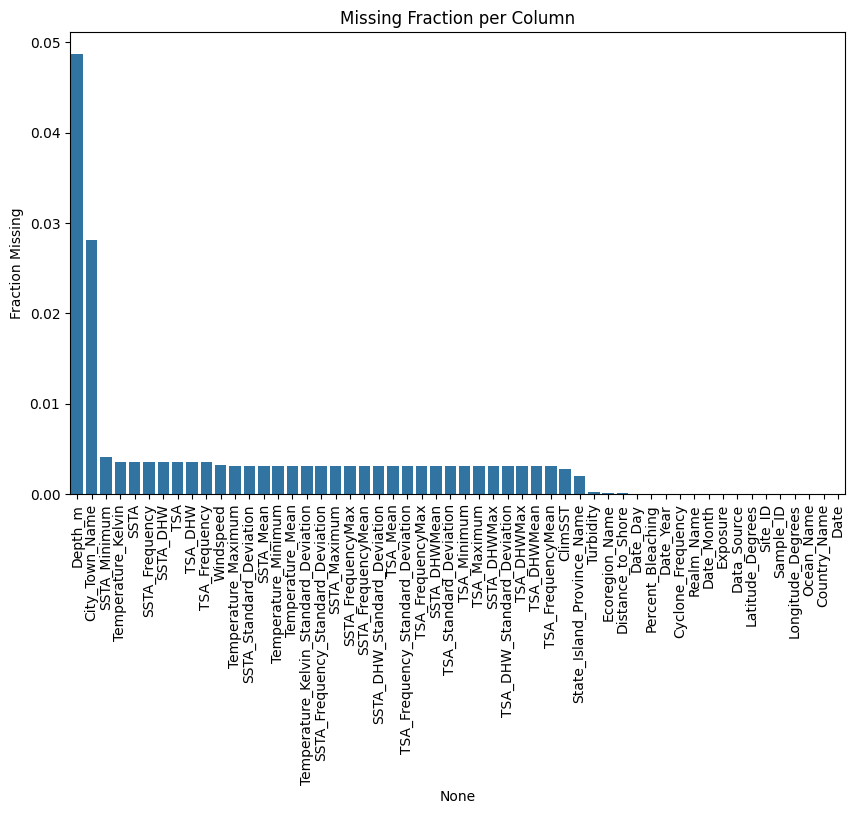

In [14]:
plt.figure(figsize=(10,6))
sns.barplot(x=missing_frac.index, y=missing_frac.values)
plt.xticks(rotation=90)
plt.ylabel("Fraction Missing")
plt.title("Missing Fraction per Column")
plt.show()

In [15]:
## are NAs at MAR (missing at random) or MNAR (missing not at random)?
## make df copy to not write in OG df

df2 = df.copy()
num_cols2 = [col for col in num_cols if col != 'Percent_Cover']

for col in num_cols2:
    df2[col + "_missing"] = df2[col].isna().astype(int)

if "Realm_Name" in df2.columns:
    print(df2.groupby("Realm_Name")[col + "_missing"].mean().sort_values(ascending=False))

print("\n")

if "Ecoregion_Name" in df2.columns:
    print(df2.groupby("Ecoregion_Name")[col + "_missing"].mean().sort_values(ascending=False))


## realm: MAR -> Ignore
## ecoregion: Gulf of Kutch India? otherwise MAR -> Ignore

Realm_Name
Eastern Indo-Pacific           0.020420
Central Indo-Pacific           0.003773
Western Indo-Pacific           0.002571
Tropical Atlantic              0.000451
Temperate Northern Atlantic    0.000000
Temperate Australasia          0.000000
Temperate Northern Pacific     0.000000
Tropical Eastern Pacific       0.000000
Name: TSA_DHWMean_missing, dtype: float64


Ecoregion_Name
Gulf of Kutch India                            0.500000
Lesser Sunda Islands and Savu Sea              0.062687
West Sumatra                                   0.034483
Society Islands French Polynesia               0.026174
Marianas                                       0.018182
                                                 ...   
Taiwan and coastal China                       0.000000
Vanuatu                                        0.000000
Western Mexico and Revillagigedo Islands       0.000000
Western Tuamotu Archipelago central Pacific    0.000000
Yap Islands Micronesia                         0.0

In [16]:
if "Date_Year" in df2.columns:
    print(df2.groupby("Date_Year")[col + "_missing"].mean().sort_values(ascending=False))

## year: 2020 missing (covid pandemic?), otherwise MAR, no time trend -> Ignore

Date_Year
2020    1.000000
1987    0.055556
2001    0.002729
2000    0.001616
1999    0.001339
2013    0.001313
1998    0.001117
2008    0.001042
2002    0.001012
2005    0.000753
2007    0.000640
2003    0.000601
1986    0.000000
1983    0.000000
1980    0.000000
1994    0.000000
1996    0.000000
1995    0.000000
1988    0.000000
1990    0.000000
2004    0.000000
1997    0.000000
1991    0.000000
1992    0.000000
1993    0.000000
2010    0.000000
2009    0.000000
2006    0.000000
2012    0.000000
2011    0.000000
2015    0.000000
2014    0.000000
2016    0.000000
2017    0.000000
2018    0.000000
2019    0.000000
Name: TSA_DHWMean_missing, dtype: float64


In [17]:
if "Date_Month" in df2.columns:
    print(df2.groupby("Date_Month")[col + "_missing"].mean().sort_values(ascending=False))

## month: maybe a pattern, 'highest' january-march, but we are talking 1.1-1.6% of all data with target value -> Ignore

Date_Month
1     0.016632
2     0.011960
3     0.011823
5     0.005066
8     0.001705
12    0.001305
6     0.000976
4     0.000707
10    0.000634
11    0.000408
7     0.000000
9     0.000000
Name: TSA_DHWMean_missing, dtype: float64


In [18]:
if "Data_Source" in df2.columns:
    print(df2.groupby("Data_Source")[col + "_missing"].mean().sort_values(ascending=False))

## data source not an issue either -> MAR -> Ignore

Data_Source
Safaie        0.012987
Reef_Check    0.004261
Donner        0.001560
AGRRA         0.000000
FRRP          0.000000
McClanahan    0.000000
Kumagai       0.000000
Nuryana       0.000000
Setiawan      0.000000
Name: TSA_DHWMean_missing, dtype: float64


In [19]:
if "Country_Name" in df2.columns:
    print(df2.groupby("Country_Name")[col + "_missing"].mean().sort_values(ascending=False))

## Samoa only country with potentially MNAR, but overall Country of origin not an issue -> mostly MAR -> Ignore

Country_Name
Samoa                                           0.250000
Indonesia                                       0.024485
French Polynesia                                0.024390
Commonwealth of the Northern Mariana Islands    0.024390
Thailand                                        0.016461
                                                  ...   
Tuvalu                                          0.000000
United Kingdom                                  0.000000
Vanuatu                                         0.000000
Vietnam                                         0.000000
Yemen                                           0.000000
Name: TSA_DHWMean_missing, Length: 89, dtype: float64


## DIMENSIONALITY REDUCTION

In [20]:
# update num_cols and cat_cols lists

num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()

# split df

num_cols_df = df[num_cols]
cat_cols_df = df[cat_cols]

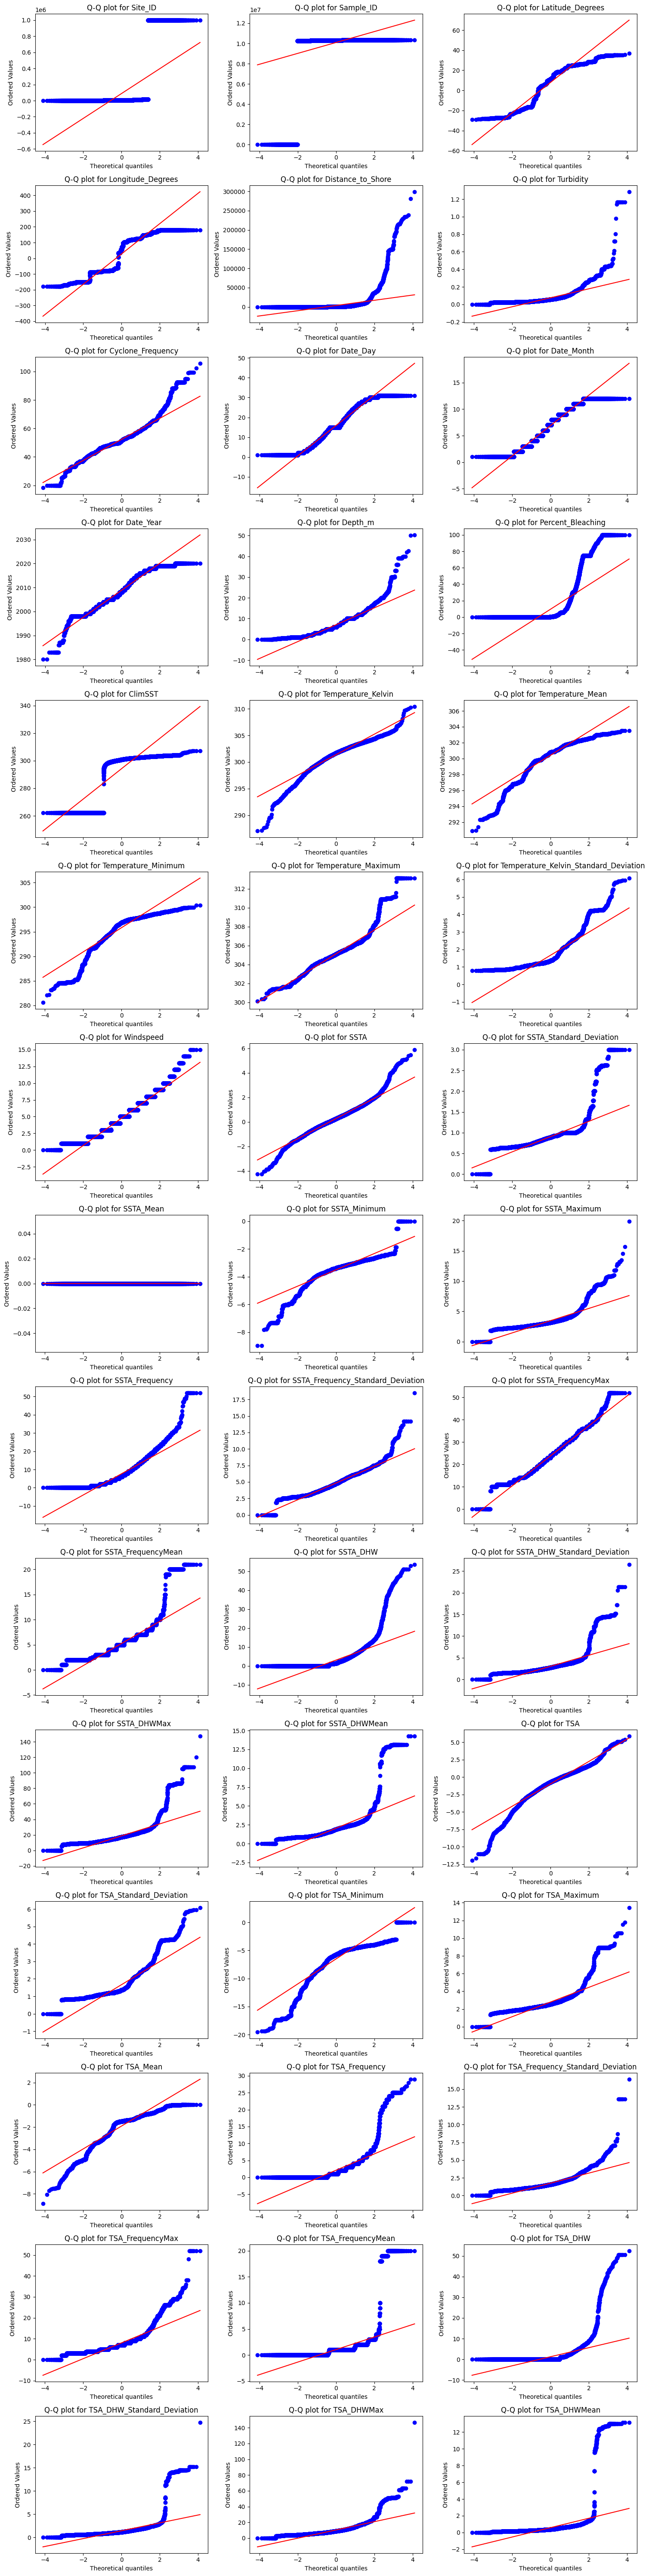

In [21]:
## visualize if numerical features are normally distributed before correlating

import scipy.stats as stats

n_cols = 3  # number of columns in the grid
n_plots = len(num_cols)

# Compute rows automatically using ceil
fig, axes = plt.subplots(nrows=int(np.ceil(n_plots/n_cols)), ncols=n_cols, figsize=(n_cols*5, np.ceil(n_plots/n_cols)*4))
axes = axes.flatten()  # flatten in case of single row/column

for i, col in enumerate(num_cols):
    stats.probplot(num_cols_df[col].dropna(), dist="norm", plot=axes[i])
    axes[i].set_title(f"Q-Q plot for {col}")

# Turn off any empty subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [22]:
## feature reduction 1: highly correlating features

## continue using 'num_cols2' bc we dropped 'Percent_Var' earlier with missing > 0.3
## spearman bc most num_cols2 are not normally distributed

corr = num_cols_df.corr(method="spearman").abs()

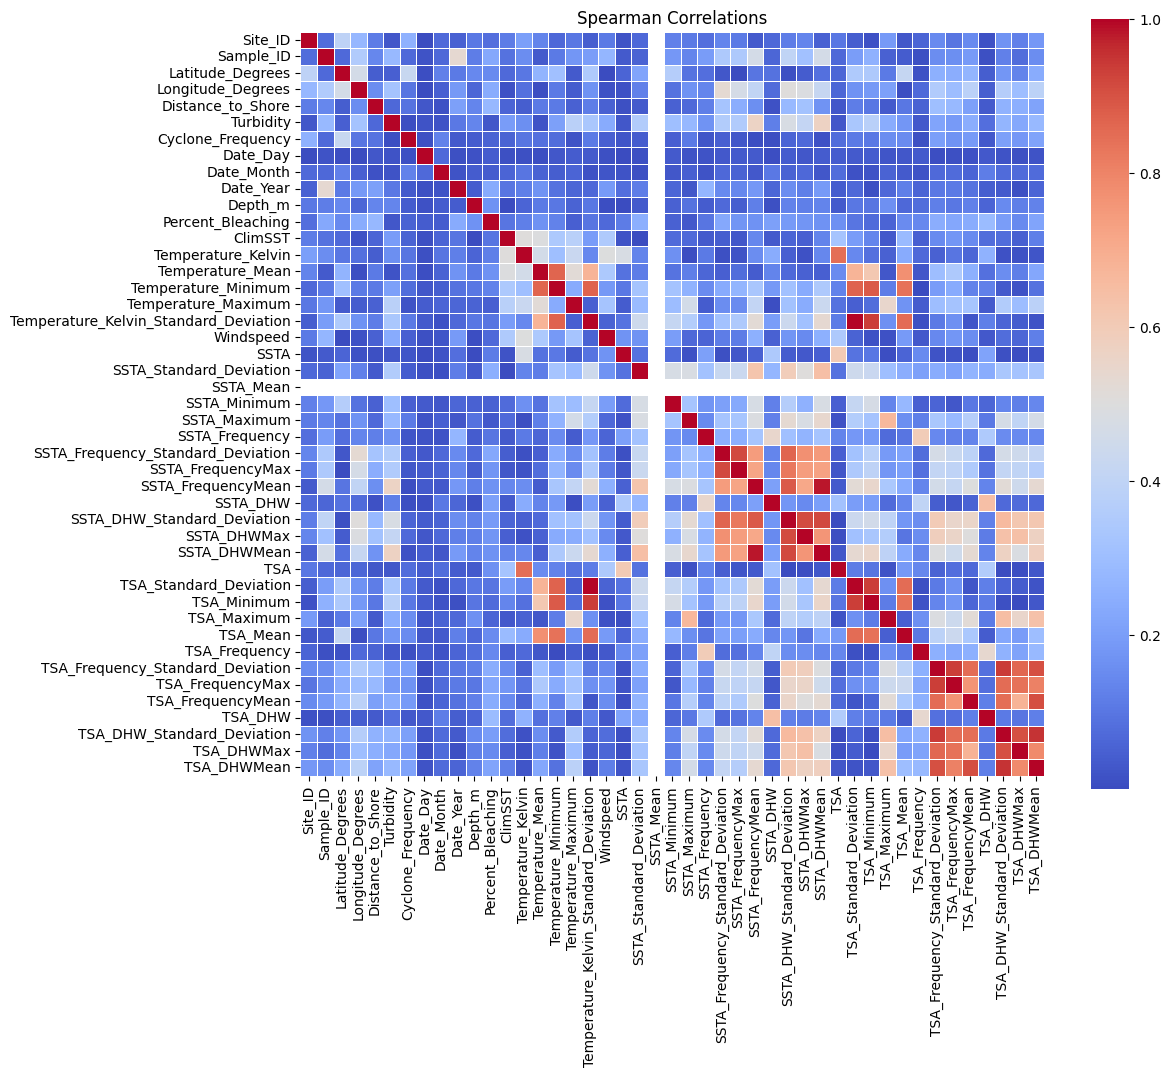

In [23]:
plt.figure(figsize=(12,10))
sns.heatmap(
    corr,
    annot=False,
    fmt=".2f",
    cmap="coolwarm",
    cbar=True,
    square=True,
    linewidths=0.5,
)
plt.title("Spearman Correlations")
plt.show()

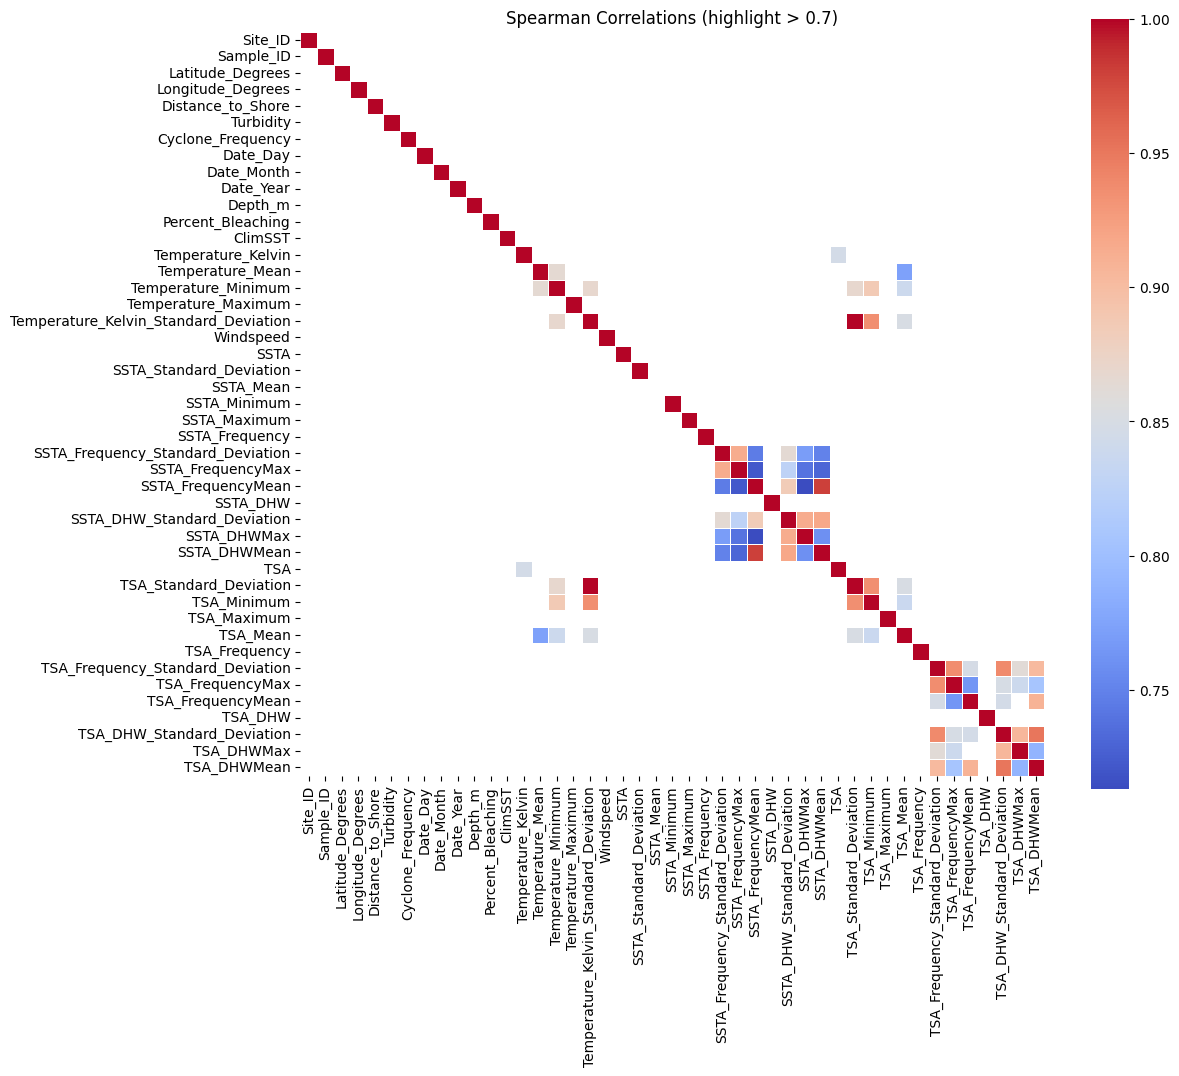

In [24]:
# Create a mask for correlations <= 0.7 for readibility reasons
mask = corr <= 0.7

plt.figure(figsize=(12,10))
sns.heatmap(
    corr,
    annot=False,
    fmt=".2f",
    cmap="coolwarm",
    cbar=True,
    square=True,
    linewidths=0.5,
    mask=mask  # hide correlations <= 0.7
)
plt.title("Spearman Correlations (highlight > 0.7)")
plt.show()

In [25]:
## update post-feature importance test: define cols_to_keep

num_cols_to_keep = ['Latitude_Degrees', 'Longitude_Degrees', 'Distance_to_Shore', 'Turbidity', 'Cyclone_Frequency', 'Date_Month', 'Date_Year', 'Depth_m', 'ClimSST', 'Temperature_Kelvin', 'Temperature_Kelvin_Standard_Deviation',
                    'Windspeed', 'SSTA', 'SSTA_DHW', 'TSA', 'TSA_DHW']

num_cols_df = num_cols_df[num_cols_to_keep]

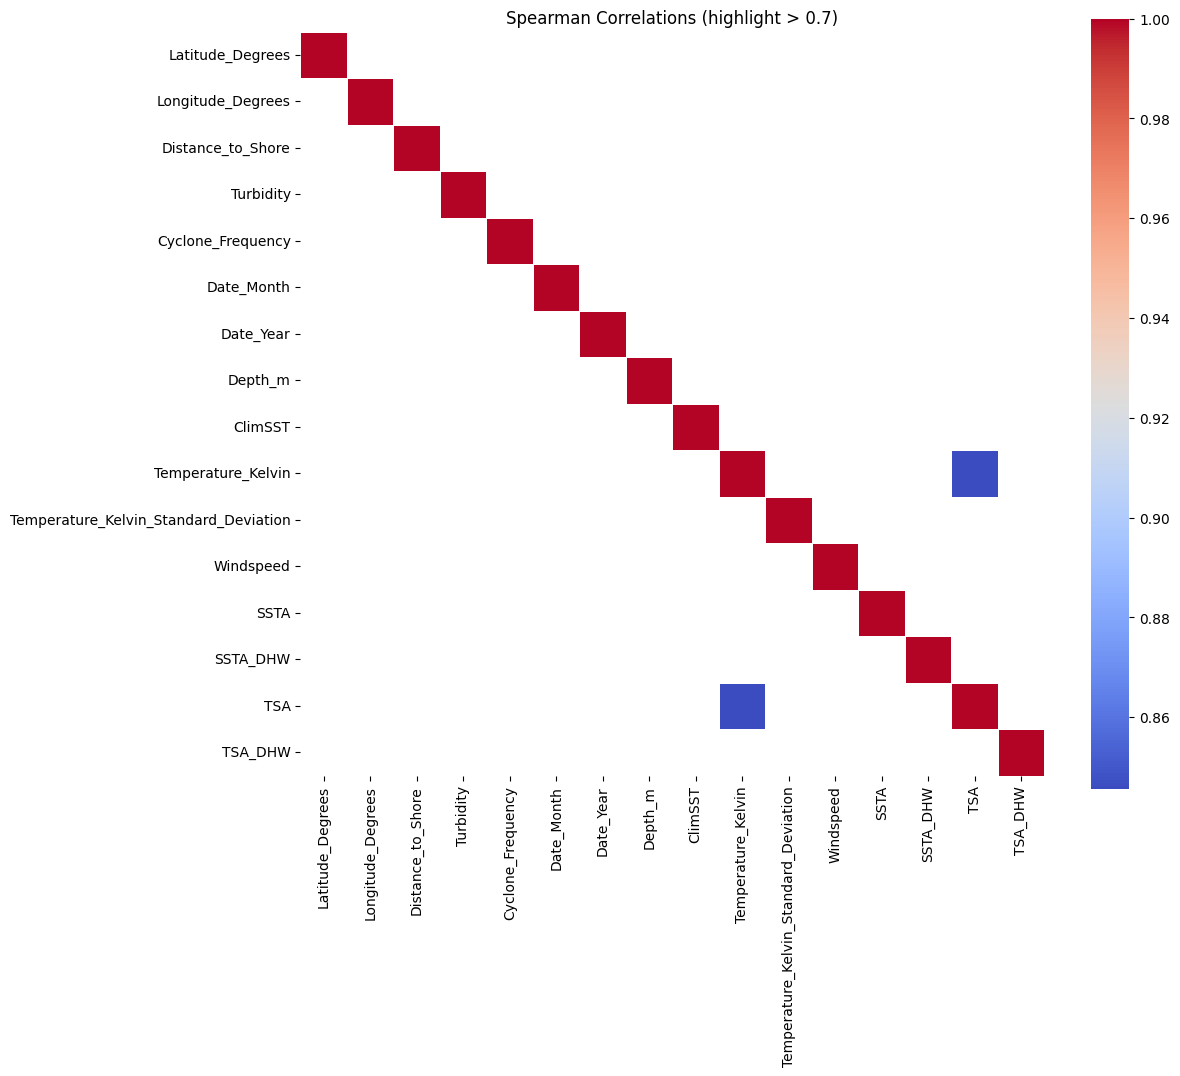

In [26]:
corr = num_cols_df.corr(method="spearman").abs()

# Create a mask for correlations <= 0.7 for readibility reasons
mask = corr <= 0.7

plt.figure(figsize=(12,10))
sns.heatmap(
    corr,
    annot=False,
    fmt=".2f",
    cmap="coolwarm",
    cbar=True,
    square=True,
    linewidths=0.5,
    mask=mask  # hide correlations <= 0.7
)
plt.title("Spearman Correlations (highlight > 0.7)")
plt.show()


In [27]:
## leave as is for now, revisit to check TSA/Temp Kelvin Corr

## TIME FEATURE ENCODING

In [28]:
## encoding time features

if "Date_Month" in num_cols_df.columns:
    num_cols_df["month_sin"] = np.sin(2 * np.pi * num_cols_df["Date_Month"]/12)
    num_cols_df["month_cos"] = np.cos(2 * np.pi * num_cols_df["Date_Month"]/12)

if "Date_Year" in num_cols_df.columns:
    num_cols_df["year_norm"] = (num_cols_df["Date_Year"] - num_cols_df["Date_Year"].mean()) / num_cols_df["Date_Year"].std()

num_cols_df = num_cols_df.drop(['Date_Year', 'Date_Month'], axis=1)

## NUMERICAL IMPUTER

In [29]:
## numerical feature imputer

## re-check strategies

num_imputer = SimpleImputer(strategy="median")

## CATEGORICAL ENCODING

In [30]:
## cat_col count unique values
unique_counts = cat_cols_df.nunique()
print(unique_counts)

## mostly OHE, so we should drop Ecoregion_Name, Country_Name, State_Island_Provence_Name, City_Town_Name, Date

Data_Source                      9
Ocean_Name                       5
Realm_Name                       8
Ecoregion_Name                 113
Country_Name                    89
State_Island_Province_Name     442
City_Town_Name                1709
Exposure                         3
Date                          4437
dtype: int64


In [31]:
cat_cols_to_drop = ['Ecoregion_Name', 'Country_Name', 'State_Island_Province_Name', 'City_Town_Name', 'Date', 'Data_Source']
cat_cols_df = cat_cols_df.drop(columns=cat_cols_to_drop)

In [32]:
## our OHE
## drop='last' drops the last category in each feature

cat_encoder = OneHotEncoder(
    handle_unknown='ignore',
    drop='last',
    sparse_output=False
)

## PREPROC: COLUMNTRANSFORMER

In [33]:
## concatenate num_cols_df and cat_cols_df

df = pd.concat([num_cols_df, cat_cols_df], axis=1)

## updating num_cols and cat_cols lists on final df

num_cols= df.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()


In [34]:
df.head()

,Latitude_Degrees,Longitude_Degrees,Distance_to_Shore,Turbidity,Cyclone_Frequency,Depth_m,ClimSST,Temperature_Kelvin,Temperature_Kelvin_Standard_Deviation,Windspeed,SSTA,SSTA_DHW,TSA,TSA_DHW,month_sin,month_cos,year_norm,Ocean_Name,Realm_Name,Exposure
0,23.163,-82.5260,8519.23,0.0287,49.90,10.00,301.61,302.05,1.60,8.0,-0.46,0.00,-0.80,0.00,-1.000000,-1.836970e-16,-0.670919,Atlantic,Tropical Atlantic,Exposed
1,-17.575,-149.7833,1431.62,0.0262,51.20,14.00,262.15,303.30,1.12,2.0,1.29,0.26,1.29,0.26,1.000000,6.123234e-17,-3.118690,Pacific,Eastern Indo-Pacific,Exposed
2,18.369,-64.5640,182.33,0.0429,61.52,7.00,298.79,299.18,1.22,8.0,0.04,0.00,-2.64,0.00,0.500000,8.660254e-01,-0.496079,Atlantic,Tropical Atlantic,Exposed
3,17.760,-64.5680,313.13,0.0424,65.39,9.02,300.16,299.61,1.19,3.0,-0.07,0.00,-2.27,0.00,0.866025,-5.000000e-01,-0.496079,Atlantic,Tropical Atlantic,Exposed
4,17.769,-64.5830,792.00,0.0424,65.39,12.50,300.15,299.70,1.18,3.0,0.00,0.00,-2.19,0.00,0.866025,-5.000000e-01,-0.496079,Atlantic,Tropical Atlantic,Exposed


In [35]:
## preproc transformer

preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", RobustScaler())
        ]), num_cols),

        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop"
)

In [36]:
## ("pca", Pipeline([
##            ("imputer", SimpleImputer(strategy="median")),
##            ("scaler", StandardScaler()),
##            ("pca", PCA(n_components=0.9))
##        ]), features)

## implement a PCA for further dimensionality reduction? Have to reread syntax
## as in the code above, we'd keep all columns that explain 90% of variability IN SELECTED SUBSET 'features'

In [37]:
## X should be like when preprocessor is final with pca:
## X = df[num_cols + cat_cols + other_cols]

X = df


In [38]:
X_processed = preprocessor.fit_transform(X)

## CTRL FOR PREPROC

In [39]:
## work done by our sixth member: AI


def get_ct_feature_names(ct: ColumnTransformer) -> list:
    """
    Extract column names from a fitted ColumnTransformer,
    including when transformers are nested inside Pipelines,
    and when remainder='passthrough' is used.
    """

    feature_names = []

    # ct.transformers_ contains (name, transformer, columns)
    for name, transformer, columns in ct.transformers_:

        # ----------------------------------------------------------
        # 1. Skip dropped columns
        # ----------------------------------------------------------
        # If a transformer is explicitly set to 'drop', skip it entirely.
        if transformer == 'drop':
            continue

        # ----------------------------------------------------------
        # 2. Handle columns left as passthrough
        # ----------------------------------------------------------
        # remainder='passthrough' means: do nothing to these columns.
        # They should be included as-is.
        if transformer == 'passthrough':
            feature_names.extend(columns)
            continue

        # ----------------------------------------------------------
        # 3. If the transformer is a Pipeline, unwrap it
        # ----------------------------------------------------------
        # Many sklearn preprocessing steps are wrapped inside a Pipeline.
        # Example: Pipeline([("imputer", ...), ("scaler", ...), ("encoder", ...)])
        #
        # Only the LAST step actually produces the final transformed features.
        # So we extract the last step.
        if hasattr(transformer, 'named_steps'):
            # Get list of steps in order and take the last one
            last_step = list(transformer.named_steps.values())[-1]

            # Replace transformer with the last step so that the next logic
            # (checking get_feature_names_out) applies to the correct object.
            transformer = last_step

        # ----------------------------------------------------------
        # 4. If transformer supports feature name expansion
        # ----------------------------------------------------------
        # Transformers like OneHotEncoder, PolynomialFeatures, PCA, etc.
        # can output MORE columns than they receive.
        #
        # Such transformers implement get_feature_names_out().
        if hasattr(transformer, 'get_feature_names_out'):
            names = transformer.get_feature_names_out(columns)

        # ----------------------------------------------------------
        # 5. Otherwise, the transformer does not change feature naming
        # ----------------------------------------------------------
        # Scalers, imputers, normalizers, and other simple transformers
        # keep the number of features constant and preserve original names.
        else:
            names = columns

        # Add derived feature names to output list
        feature_names.extend(names)

    return feature_names

In [40]:
feature_names = get_ct_feature_names(preprocessor)
X_processed_df = pd.DataFrame(X_processed, columns=feature_names, index=X.index)

In [41]:
X_processed_df.describe()

,Latitude_Degrees,Longitude_Degrees,Distance_to_Shore,Turbidity,Cyclone_Frequency,Depth_m,ClimSST,Temperature_Kelvin,Temperature_Kelvin_Standard_Deviation,Windspeed,...,Realm_Name_Eastern Indo-Pacific,Realm_Name_Temperate Australasia,Realm_Name_Temperate Northern Atlantic,Realm_Name_Temperate Northern Pacific,Realm_Name_Tropical Atlantic,Realm_Name_Tropical Eastern Pacific,Realm_Name_Western Indo-Pacific,Exposure_Exposed,Exposure_Sheltered,Exposure_Sometimes
count,34515.000000,34515.000000,34515.000000,34515.000000,34515.000000,34515.000000,34515.000000,34515.000000,34515.000000,34515.000000,...,34515.000000,34515.000000,34515.000000,34515.000000,34515.000000,34515.000000,34515.000000,34515.000000,34515.000000,34515.000000
mean,-0.135778,-0.144953,1.868572,0.415889,0.116387,0.166909,-1.936437,-0.139511,0.337831,-0.080634,...,0.049660,0.015529,0.000406,0.014718,0.385485,0.002723,0.101434,0.354542,0.565088,0.080371
std,0.650831,0.523559,7.825650,1.389943,0.935651,0.689300,4.333599,0.827258,0.796704,0.688625,...,0.217244,0.123648,0.020136,0.120424,0.486717,0.052116,0.301907,0.478381,0.495753,0.271870
min,-1.653573,-1.181928,-0.276462,-1.278027,-4.072660,-1.000000,-11.332845,-6.138075,-0.626374,-1.666667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.624412,-0.682737,-0.204521,-0.390135,-0.423645,-0.333333,-0.649560,-0.573222,-0.197802,-0.666667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.375588,0.317263,0.795479,0.609865,0.576355,0.666667,0.350440,0.426778,0.802198,0.333333,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.048591,0.618426,174.673576,27.522422,6.701970,7.383333,1.884164,3.652720,5.186813,3.333333,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [42]:
X_processed_df.shape

(34515, 33)

## OPEN DISCUSSION: TARGET BALANCE

<Axes: ylabel='Frequency'>

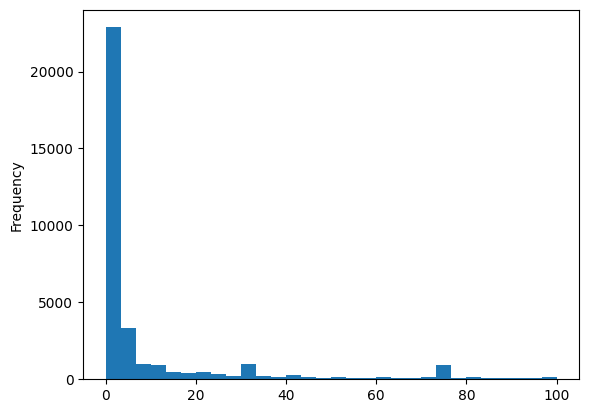

In [43]:
## from Lucia

y.plot(kind='hist', bins=30)

## discuss: target balancing? necessary if numeric?

In [44]:
## from Lucia

y_df = pd.DataFrame(y)
y_df = y_df.set_axis(['Percent_Bleaching'], axis=1)

sites_healthy = y_df[y_df["Percent_Bleaching"] == 0]
len(sites_healthy)/len(y_df)*100

## discretizing target (healthy = 0% bleaching vs bleaching = > 0% bleaching) would leave a balanced target feature of class

48.17905258583225

In [45]:
## make target categorical

y_cat = ['healthy' if y == 0 else 'bleached' for y in y]

healthy_count = y_cat.count('healthy')
bleached_count = y_cat.count('bleached')

print(healthy_count*100/(healthy_count + bleached_count), bleached_count*100/(healthy_count + bleached_count))

48.179052585832245 51.820947414167755


In [46]:
mapping = {'healthy': 0, 'bleached': 1}
y_encoded = [mapping[v] for v in y_cat]


## MODEL

In [47]:
## Which models make sense?

## Random Forest
## XGBoost
## Logistic models / ElasticNet
## Neural networks (later)

In [48]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb

In [49]:
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_encoded, test_size=0.2, random_state=42
)

## V1: SIMPLE CLASSIFIER COMPARISON

In [50]:
models = {
    "RandomForest": RandomForestClassifier(
        n_estimators=300, random_state=42, n_jobs=-1
    ),

    "GradientBoosting": GradientBoostingClassifier(
        n_estimators=300, learning_rate=0.05, random_state=42
    ),

    "XGBoost": xgb.XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=42
    ),

    "LogisticElasticNet": LogisticRegression(
        penalty="elasticnet",
        solver="saga",
        l1_ratio=0.5,
        max_iter=5000,
        random_state=42
    ),
    "LogisticRegressionClassic": LogisticRegression(
    penalty="l2",
    solver="lbfgs",
    max_iter=2000,
    random_state=42
    )
}


In [51]:
def compare_classifiers(preprocessor, X_train, X_test, y_train, y_test):
    results = []

    for name, model in models.items():
        print(f"\n============================")
        print(f"Training {name}...")
        print(f"============================")

        pipe = Pipeline([
            #("preprocess", preprocessor),
            ("clf", model)
        ])

        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        y_prob = pipe.predict_proba(X_test)[:, 1]

        metrics = {
            "Model": name,
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred),
            "Recall": recall_score(y_test, y_pred),
            "F1": f1_score(y_test, y_pred),
            "ROC_AUC": roc_auc_score(y_test, y_prob),
            "Pipeline": pipe,
        }

        results.append(metrics)

    df_results = pd.DataFrame(results).drop(columns=["Pipeline"])
    return df_results, results

In [52]:
results_df, results_objects = compare_classifiers(
    preprocessor, X_train, X_test, y_train, y_test
)


Training RandomForest...

Training GradientBoosting...

Training XGBoost...

Training LogisticElasticNet...

Training LogisticRegressionClassic...


In [53]:
print(results_df)

                       Model  Accuracy  Precision    Recall        F1  \
0               RandomForest  0.954368   0.958040  0.953475  0.955752   
1           GradientBoosting  0.802550   0.844855  0.757007  0.798522   
2                    XGBoost  0.861799   0.896541  0.828195  0.861014   
3         LogisticElasticNet  0.722440   0.730212  0.734305  0.732253   
4  LogisticRegressionClassic  0.722584   0.729903  0.735426  0.732654   

    ROC_AUC  
0  0.983479  
1  0.882095  
2  0.936570  
3  0.786172  
4  0.786229  


## V2: GridSearch FOR CLASSIFIERS

In [ ]:
## maximizing model performance by GridSearching hyperparameters

In [ ]:
param_grids = {
    "RandomForest": {
        "clf__n_estimators": [200, 400],
        "clf__max_depth": [None, 10, 20],  ## re-check documentation
        "clf__min_samples_split": [2, 5],  ## re-check documentation
    },

    "GradientBoosting": {
        "clf__n_estimators": [200, 400],
        "clf__learning_rate": [0.05, 0.1],
        "clf__max_depth": [2, 3],
    },

    "XGBoost": {
        "clf__n_estimators": [200, 400],
        "clf__learning_rate": [0.03, 0.1],
        "clf__max_depth": [4, 6],
        "clf__subsample": [0.8, 1.0],  ## re-check documentation
    },

    "LogisticElasticNet": {
        "clf__C": [0.1, 1, 10],
        "clf__l1_ratio": [0.2, 0.5, 0.8],
    },
    "LogisticRegressionClassic": {
        "clf__C": [0.01, 0.1, 1, 10, 100],
    }
}

## rationale for now:
## n hyperparameters = 1 -> fully test
## n hyperparameters > 1 -> minimize alt parameters across hyperparameters in order to test if there is enough room for improvement here (test scoring)

In [ ]:
def compare_classifiers_with_gridsearch(preprocessor, X_train, X_test, y_train, y_test):
    results = []

    for name, model in models.items():
        print(f"\n============================")
        print(f"Tuning + Training {name}...")
        print(f"============================")

        pipe = Pipeline([
            #("preprocess", preprocessor),
            ("clf", model)
        ])

        grid = GridSearchCV(
            estimator=pipe,
            param_grid=param_grids[name],
            cv=3,
            scoring="f1",         # best metric for balanced classes
            n_jobs=-1,
            verbose=2
        )

        grid.fit(X_train, y_train)

        best_model = grid.best_estimator_
        y_pred = best_model.predict(X_test)
        y_prob = best_model.predict_proba(X_test)[:, 1]

        metrics = {
            "Model": name,
            "Best_Params": grid.best_params_,
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred),
            "Recall": recall_score(y_test, y_pred),
            "F1": f1_score(y_test, y_pred),
            "ROC_AUC": roc_auc_score(y_test, y_prob),
            "Pipeline": best_model,
        }

        results.append(metrics)

    df_results = pd.DataFrame(results).drop(columns=["Pipeline"])
    return df_results, results


In [93]:
results_df, results_objects = compare_classifiers_with_gridsearch(
    preprocessor, X_train, X_test, y_train, y_test
)

results_df


Tuning + Training RandomForest...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END clf__max_depth=None, clf__min_samples_split=2, clf__n_estimators=200; total time=  25.1s
[CV] END clf__max_depth=None, clf__min_samples_split=2, clf__n_estimators=200; total time=  25.2s
[CV] END clf__max_depth=None, clf__min_samples_split=2, clf__n_estimators=200; total time=  25.2s
[CV] END clf__max_depth=None, clf__min_samples_split=2, clf__n_estimators=400; total time=  47.2s
[CV] END clf__max_depth=None, clf__min_samples_split=5, clf__n_estimators=200; total time=  23.0s
[CV] END clf__max_depth=None, clf__min_samples_split=2, clf__n_estimators=400; total time=  48.1s
[CV] END clf__max_depth=None, clf__min_samples_split=5, clf__n_estimators=200; total time=  25.9s
[CV] END clf__max_depth=None, clf__min_samples_split=5, clf__n_estimators=200; total time=  25.3s
[CV] END clf__max_depth=None, clf__min_samples_split=2, clf__n_estimators=400; total time=  48.6s
[CV] END clf__max_dept

/home/nico_kas/.pyenv/versions/ReefSight-Project/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .........................................clf__C=100; total time=  21.7s
[CV] END .........................................clf__C=100; total time=  11.4s


,Model,Best_Params,Accuracy,Precision,Recall,F1,ROC_AUC
0,RandomForest,"{'clf__max_depth': None, 'clf__min_samples_spl...",0.955816,0.960746,0.953475,0.957097,0.985156
1,GradientBoosting,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",0.839345,0.889205,0.787276,0.835142,0.921343
2,XGBoost,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",0.906128,0.927651,0.887612,0.907190,0.968160
3,LogisticElasticNet,"{'clf__C': 1, 'clf__l1_ratio': 0.5}",0.763871,0.837631,0.673767,0.746816,0.839181
4,LogisticRegressionClassic,{'clf__C': 1},0.764450,0.838800,0.673767,0.747280,0.839686


In [ ]:
## there is little (XGBoost, GradientBoosting) to no (RandomForest, Logostic) improvement on the performance of all models

In [ ]:
## Why F1 for scoring?

## = "harmonic mean of precison and recall"

## Most robust when...

## ...classes may not be perfectly balanced (even if they look balanced now)
## ...false positives and false negatives need equal importance
## b..catching bleaching events while not generating too many false alarms

## Ask yourself...

## accuracy: prone to even mild imbalances......
## precision: if the model predicts bleaching, how often is it right?
## recall (sensitivity): what fraction of actual bleaching events are detected?

## V3: EXTRACTING MOST IMPORTANT FEATURES PER CLASSIFIER ON BEST GRIDSEARCH PARAMS

In [50]:
models_minimal = {
    "RandomForestClassifier": RandomForestClassifier(
        n_estimators=300, random_state=42, n_jobs=-1
    ),

    "XGBClassifier": xgb.XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=42
    ),

    "LogisticRegression": LogisticRegression(
    penalty="l2",
    solver="lbfgs",
    max_iter=2000,
    random_state=42
    )
}

In [51]:
param_grids_v2 = {
    "RandomForestClassifier": {
        "clf__n_estimators": [100, 200, 400],
        "clf__max_depth": [None, 5, 10],
        "clf__min_samples_split": [2, 5, 10],
        #"clf__max_features": stats.randint(1, len(X.columns)) # default None, i.e = n_features
    },

    "XGBClassifier": {
        "clf__n_estimators": [100, 200, 400],
        "clf__learning_rate": [0.01, 0.05, 0.1, 0.5],
        "clf__max_depth": [None, 5, 10],
        "clf__subsample": [0.8, 1.0],  ## re-check documentation
    },

    "LogisticRegression": {
        "clf__C": [0.01, 0.1, 1, 10],
    }
}

In [52]:
## adjust grid search to avoid overwriting 'best_model' with each loop iteration, otherwise only the last model from 'models' will be retrieved in 'best_model'.
## instead, have best model dictionary (fitted_models) AND pass it to return

def compare_classifiers_with_gridsearch_v2(preprocessor, X_train, X_test, y_train, y_test):
    results = []
    fitted_models = {}  # to store best estimators for all (!) models

    for name, model in models_minimal.items():
        print(f"\n============================")
        print(f"Tuning + Training {name}...")
        print(f"============================")

        pipe = Pipeline([
            #("preprocess", preprocessor),  # include preprocessing
            ("clf", model)
        ])

        grid = GridSearchCV(
            estimator=pipe,
            param_grid=param_grids_v2[name],
            cv=3,
            scoring="f1",         # best metric for balanced classes
            n_jobs=-1,
            verbose=2
        )

        grid.fit(X_train, y_train)

        # Store each (!) best model by name instead of overwriting
        fitted_models[name] = grid.best_estimator_

        # pass current best model (classifier being grid searched in this iteration) to 'best_model'
        best_model = fitted_models[name]
        y_pred = best_model.predict(X_test)
        y_prob = best_model.predict_proba(X_test)[:, 1]

        metrics = {
            "Model": name,
            "Best_Params": grid.best_params_,
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred),
            "Recall": recall_score(y_test, y_pred),
            "F1": f1_score(y_test, y_pred),
            "ROC_AUC": roc_auc_score(y_test, y_prob),
            "Pipeline": best_model,
        }

        results.append(metrics)

    df_results = pd.DataFrame(results).drop(columns=["Pipeline"])
    return df_results, results, fitted_models

In [53]:
## function to export feature importances for each grid searched model from 'compare_classifiers_with_gridsearch_v2'
## -> fitted_models dictionary can be passed, but needs to be put in loop and iterate over models in dict

def get_feature_importances(model, feature_names):
    """
    Takes a trained model and list of feature names and returns
    a sorted DataFrame with feature importances.
    Handles:
        - RandomForest, GradientBoosting
        - XGBoost
        - Logistic Regression (coefficients)
        - Models without feature importance (skips): knn, CNN, ...
    """

    # 1. Tree-based models
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_

    # 2. Logistic regression (use coefficients bc there is no 'feature_importance' metric)
    elif hasattr(model, "coef_"):
        # if binary classification -> shape (1, n_features)
        importances = model.coef_[0]

    else:
        raise ValueError(f"Model of type {type(model)} does not support feature importance.")

    # Build dataframe
    fi = pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    })

    # Sort highest -> lowest
    fi = fi.sort_values("importance", ascending=False).reset_index(drop=True)

    return fi

In [54]:
results_df, results_objects, fitted_models = compare_classifiers_with_gridsearch_v2(
    preprocessor, X_train, X_test, y_train, y_test
)


Tuning + Training RandomForestClassifier...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END clf__max_depth=None, clf__min_samples_split=2, clf__n_estimators=100; total time=  14.0s
[CV] END clf__max_depth=None, clf__min_samples_split=2, clf__n_estimators=100; total time=  13.9s
[CV] END clf__max_depth=None, clf__min_samples_split=2, clf__n_estimators=100; total time=  14.0s
[CV] END clf__max_depth=None, clf__min_samples_split=2, clf__n_estimators=200; total time=  23.8s
[CV] END clf__max_depth=None, clf__min_samples_split=2, clf__n_estimators=200; total time=  25.3s
[CV] END clf__max_depth=None, clf__min_samples_split=2, clf__n_estimators=200; total time=  25.7s
[CV] END clf__max_depth=None, clf__min_samples_split=5, clf__n_estimators=100; total time=  10.4s
[CV] END clf__max_depth=None, clf__min_samples_split=2, clf__n_estimators=400; total time=  45.3s
[CV] END clf__max_depth=None, clf__min_samples_split=5, clf__n_estimators=100; total time=   9.7s
[CV] END clf

In [63]:
results_df

,Model,Best_Params,Accuracy,Precision,Recall,F1,ROC_AUC
0,RandomForest,"{'clf__max_depth': None, 'clf__min_samples_spl...",0.954368,0.958557,0.952915,0.955727,0.983366
1,XGBoost,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",0.943937,0.948407,0.942825,0.945608,0.978988
2,LogisticRegressionClassic,{'clf__C': 10},0.722150,0.729805,0.734305,0.732048,0.786263


In [59]:
# 1. Get feature names from preprocessor
feature_names = get_ct_feature_names(preprocessor)

In [60]:
feature_names

['Latitude_Degrees',
 'Longitude_Degrees',
 'Distance_to_Shore',
 'Turbidity',
 'Cyclone_Frequency',
 'Depth_m',
 'ClimSST',
 'Temperature_Kelvin',
 'Temperature_Kelvin_Standard_Deviation',
 'Windspeed',
 'SSTA',
 'SSTA_DHW',
 'TSA',
 'TSA_DHW',
 'month_sin',
 'month_cos',
 'year_norm',
 'Ocean_Name_Arabian Gulf',
 'Ocean_Name_Atlantic',
 'Ocean_Name_Indian',
 'Ocean_Name_Pacific',
 'Ocean_Name_Red Sea',
 'Realm_Name_Central Indo-Pacific',
 'Realm_Name_Eastern Indo-Pacific',
 'Realm_Name_Temperate Australasia',
 'Realm_Name_Temperate Northern Atlantic',
 'Realm_Name_Temperate Northern Pacific',
 'Realm_Name_Tropical Atlantic',
 'Realm_Name_Tropical Eastern Pacific',
 'Realm_Name_Western Indo-Pacific',
 'Exposure_Exposed',
 'Exposure_Sheltered',
 'Exposure_Sometimes']

In [61]:
# 2. Get importance ranking

for name, model in fitted_models.items():
    fi_df = get_feature_importances(model.named_steps["clf"], feature_names)
    print(name, fi_df.head(20))

RandomForest                                   feature  importance
0                       Longitude_Degrees    0.094612
1                               year_norm    0.085304
2                        Latitude_Degrees    0.078955
3                                 Depth_m    0.073266
4                       Distance_to_Shore    0.067369
5   Temperature_Kelvin_Standard_Deviation    0.053669
6                      Temperature_Kelvin    0.051687
7                                     TSA    0.050270
8                       Cyclone_Frequency    0.047374
9                                    SSTA    0.044504
10                                ClimSST    0.044455
11                              Turbidity    0.042622
12                               SSTA_DHW    0.038700
13                                TSA_DHW    0.036207
14                    Ocean_Name_Atlantic    0.030739
15                              month_sin    0.029734
16                              Windspeed    0.026779
17             

## V4: ITERATIVE FEATURE REDUCTION BASED ON MODEL PERFORMANCE

In [55]:
def get_feature_ranking(best_model, model_name):
    """
    Extract features and their importances from a fitted pipeline.
    Returns a DataFrame sorted by importance descending.
    """

    feature_names = get_ct_feature_names(preprocessor)

    clf = best_model.named_steps["clf"]

    # Extract importances
    if hasattr(clf, "feature_importances_"):
        importances = clf.feature_importances_
    elif hasattr(clf, "coef_"):
        importances = np.abs(clf.coef_).ravel()
    else:
        raise ValueError(f"Model {model_name} has no feature importance attribute.")

    ranking = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    }).sort_values("Importance", ascending=False)

    return ranking


In [67]:
def evaluate_top_k_features(best_model, X_train, y_train, X_test, y_test, ks=[5,10,15,20,30,50], baseline_f1=None, delta=0.01):
    """
    Iteratively retrain the model on top-k features and evaluate.
    Stops when performance drops below baseline - delta.
    Returns the best subset size and scores.
    """
    ranking = get_feature_ranking(best_model, "model")
    feature_names = ranking["Feature"].tolist()

    # un-comment if fitted pipe contains preproc as well - here I used preproc separately
    #pre = best_model.named_steps["preprocess"]
    clf = best_model.named_steps["clf"]

    results = []

    for k in ks:
        selected_features = feature_names[:k]

        # un-comment if fitted pipe contains preproc as well - here I used preproc separately
        # Transform X_train/X_test
        #X_train_k = pre.transform(X_train)
        #X_test_k = pre.transform(X_test)

        # redundant, but for the sake of not changing the code too much...
        X_train_k = X_train
        X_test_k = X_test

        # Keep only top-k columns
        feature_indices = [i for i, f in enumerate(feature_names) if f in selected_features]
        X_train_k = X_train_k[:, feature_indices]
        X_test_k = X_test_k[:, feature_indices]

        # Clone classifier to avoid refit issues
        from sklearn.base import clone
        clf_k = clone(clf)
        clf_k.fit(X_train_k, y_train)

        y_pred = clf_k.predict(X_test_k)
        f1 = f1_score(y_test, y_pred)
        acc = accuracy_score(y_test, y_pred)

        results.append({"k": k, "Accuracy": acc, "F1": f1})

        # Stop if performance drops below baseline - delta
        if baseline_f1 is not None and f1 < (baseline_f1 - delta):
            break

    results_df = pd.DataFrame(results)
    best_subset = results_df.loc[results_df["F1"].idxmax()]
    return best_subset, results_df


In [ ]:
# uses fitted pipeline best model from...:
# df_results, , results_objects, fitted_models = compare_classifiers_with_gridsearch_v2(...)

# Pick classifier ("RandomForest", "XGBoost", "LogisticRegressionClassic")
best_model = fitted_models["RandomForestClassifier"]

# Evaluate baseline F1 on all features
y_pred_full = best_model.predict(X_test)
baseline_f1 = f1_score(y_test, y_pred_full)

# Run top-k iterative evaluation
best_subset, topk_results = evaluate_top_k_features(best_model, X_train, y_train, X_test, y_test,
                                                    ks=[50,30,20,10,5],
                                                    baseline_f1=baseline_f1, delta=0.05)

#print("Best top-k subset:", best_subset)
print(topk_results)


    k  Accuracy        F1
0  50  0.954368  0.955727
1  30  0.952340  0.953747
2  20  0.952195  0.953573
3  10  0.947124  0.948526
4   5  0.842967  0.844699


In [82]:
feature_names[:10]

['Latitude_Degrees',
 'Longitude_Degrees',
 'Distance_to_Shore',
 'Turbidity',
 'Cyclone_Frequency',
 'Depth_m',
 'ClimSST',
 'Temperature_Kelvin',
 'Temperature_Kelvin_Standard_Deviation',
 'Windspeed']

In [ ]:
## lacks hyperparameter re-optimization after feature subsetting according to ranking of importance and ks

In [ ]:
## problem with SelectFromModel (deleted already, but for learning): all approaches above optimize accuracy, not parsimony

## feature selection is used to max model performance, not to minimize features while maintaining performance, only removes features that are clearly uninformative

## it never tries to find the minimum number of features for comparable performance and it does not penalize the use of more features (no sparsity penalty)

## -> feature reduction (simple)

## Recursive Feature Elimination (RFE/RFECV) too expensive computationally as it fits + scores model, removes least important feature, repeats
## ~60 features * 5  cv folds = 300 model fits per RFE iteration PER CLASSIFIER CANDIDATE

In [56]:
param_grids_no_pipe = {
    "RandomForestClassifier": {
        "n_estimators": [100, 200, 400],
        "max_depth": [None, 5, 10],
        "min_samples_split": [2, 5, 10],
        #"clf__max_features": stats.randint(1, len(X.columns)) # default None, i.e = n_features
    },

    "XGBClassifier": {
        "n_estimators": [100, 200, 400],
        "learning_rate": [0.01, 0.05, 0.1, 0.5],
        "max_depth": [None, 5, 10],
        "subsample": [0.8, 1.0],  ## re-check documentation
    },

    "LogisticRegression": {
        "C": [0.01, 0.1, 1, 10],
    }
}

In [57]:
def evaluate_top_k_features_with_gridsearch(best_model, X_train, y_train, X_test, y_test, ks=[5,10,15,20,30,50], baseline_f1=None, delta=0.01):
    """
    Iteratively retrain the model on top-k features and evaluate.
    Stops when performance drops below baseline - delta.
    Returns the best subset size and scores.
    """
    ranking = get_feature_ranking(best_model, "model")
    feature_names = ranking["Feature"].tolist()

    # un-comment if fitted pipe contains preproc as well - here I used preproc separately
    #pre = best_model.named_steps["preprocess"]
    clf = best_model.named_steps["clf"]
    clf_name = type(clf).__name__

    results = []

    for k in ks:
        selected_features = feature_names[:k]

        # redundant, but for the sake of not changing the code too much...
        X_train_k = X_train
        X_test_k = X_test

        # Keep only top-k columns
        feature_indices = [i for i, f in enumerate(feature_names) if f in selected_features]
        X_train_k = X_train_k[:, feature_indices]
        X_test_k = X_test_k[:, feature_indices]

        from sklearn.base import clone
        grid = GridSearchCV(
            estimator=clone(clf),
            param_grid=param_grids_no_pipe[clf_name],
            cv=3,
            scoring="f1",
            n_jobs=-1,
            verbose=1
        )
        grid.fit(X_train_k, y_train)
        best_clf_k = grid.best_estimator_

        y_pred = best_clf_k.predict(X_test_k)
        f1 = f1_score(y_test, y_pred)
        acc = accuracy_score(y_test, y_pred)

        results.append({
            "k": k,
            "Accuracy": acc,
            "F1": f1,
            "Best_Params": grid.best_params_,
            "Best_Estimator": best_clf_k
        })

        # Stop if performance drops below baseline - delta
        if baseline_f1 is not None and f1 < (baseline_f1 - delta):
            break

    results_df = pd.DataFrame(results)
    best_subset = results_df.loc[results_df["F1"].idxmax()]
    return best_subset, results_df, results


In [58]:
best_model = fitted_models["RandomForestClassifier"]
y_pred_full = best_model.predict(X_test)
baseline_f1 = f1_score(y_test, y_pred_full)
best_subset, topk_results, results = evaluate_top_k_features_with_gridsearch(best_model, X_train, y_train, X_test, y_test,
                                                    ks=[50,30,20,10,5],
                                                    baseline_f1=baseline_f1, delta=0.05)
print(topk_results)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits


/home/nico_kas/.pyenv/versions/ReefSight-Project/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits
    k  Accuracy        F1                                        Best_Params  \
0  50  0.954368  0.955727  {'max_depth': None, 'min_samples_split': 2, 'n...   
1  30  0.953209  0.954552  {'max_depth': None, 'min_samples_split': 2, 'n...   
2  20  0.952195  0.953573  {'max_depth': None, 'min_samples_split': 2, 'n...   
3  10  0.947124  0.948526  {'max_depth': None, 'min_samples_split': 2, 'n...   
4   5  0.842967  0.844699  {'max_depth': None, 'min_samples_split': 2, 'n...   

                                      Best_Estimator  
0  (DecisionTreeClassifier(max_features='sqrt', r...  
1  (DecisionTreeClassifier(max_features='sqrt', r...  
2  (DecisionTreeClassifier(max_features='sqrt', r...  
3  (DecisionTreeClassifier(max_features='sqrt', r...  
4  (DecisionTreeClassifier(max_features='sqrt', r...  


In [59]:
## how to choose the model to keep

chosen_k = 10   # example, YOU decide after inspection

# Find the matching dict:
chosen_entry = next(r for r in results if r["k"] == chosen_k)
chosen_model = chosen_entry["Best_Estimator"]

In [ ]:
## save preprocessor and best model

In [60]:
pwd

'/home/nico_kas/code/Lucia-Cordero/ReefSight-Project/notebooks'

In [63]:
import dill

# Enables serializing external/nested functions
dill.settings['recurse'] = True

# Save from your notebook
with open("../tabular/preprocessor/preproc_tabular.dill", "wb") as f:
    dill.dump(preprocessor, f)

# Save from your notebook
with open("../tabular/model/best_model_tabular.dill", "wb") as f:
    dill.dump(chosen_model, f)

In [ ]:
## load

In [ ]:
# Load in your Docker image
with open("../tabular/preprocessor/preproc_tabular.dill", "rb") as f:
    preprocessor_loaded = dill.load(f)